# K-Means Clustering on Large Dataset of Tweets

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

In [60]:
inp = "large"

if inp == "large":
    tweets_df = pd.read_csv('Challenge1_Large.csv')
    # np.random.seed(18)
    # remove_n = 90000
    # drop_indices = np.random.choice(tweets_df.index, remove_n, replace=False)
    # tweets_df = tweets_df.drop(drop_indices)

else:
    tweets_df = pd.read_csv('Challenge1_Medium.csv')

tweets_df = tweets_df.drop_duplicates(subset=['text'])

text = tweets_df.text.to_list()
len(text)

111271

In [61]:
def clean_text(text):
    pattern = re.compile(r'\\[a-z0-9]{3}\\[a-z0-9]{3}\\[a-z0-9]{3}')
    pattern2 = re.compile(r'\"b\'')
    req_list = []
    for ele in text:
        ele = str(ele)
        if "\\xe2\\x80\\x99" in ele:
            req_string = re.sub(re.compile(r"\\xe2\\x80\\x99"), "\'", ele)
        else:
            req_string = ele    
        
        req_string = req_string.replace("RT @", "")
        req_string = re.sub(pattern, "", req_string)
        req_string = re.sub(re.compile(r'\\n'), "", req_string)
        req_string = req_string.replace('"','').replace('b\'',"")
        req_list.append(req_string)
    return req_list

In [62]:
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Ref: https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

def preprocess(df, col, new_col):
    def remove_punctuation(text):
        return "".join([k for k in text if k not in string.punctuation])
        
        #storing the puntuation free text
    df[new_col]= df[col].apply(lambda x:remove_punctuation(x))
    df[new_col]= df[new_col].apply(lambda x: x.lower())

    def tokenization(text):
        return re.split('W+',text)
    #applying function to the column
    df[new_col]= df[new_col].apply(lambda x: tokenization(x))

    stopwords = nltk.corpus.stopwords.words('english')
    def remove_stopwords(text):
        return [k for k in text if k not in stopwords]

    df[new_col]= df[new_col].apply(lambda x:remove_stopwords(x))

    porter_stemmer = PorterStemmer()

    def stemming(text):
        return [porter_stemmer.stem(word) for word in text]

    df[new_col] = df[new_col].apply(lambda x: stemming(x))

    wordnet_lemmatizer = WordNetLemmatizer()
    def lemmatizer(text):
        return [wordnet_lemmatizer.lemmatize(word) for word in text]
    df[new_col]=df[new_col].apply(lambda x:lemmatizer(x))



    count = 0
    for i, row in df.iterrows():
        if(len(row[new_col]) == 0):
            df.iloc[i][new_col] = [" "]

    flattened  = [val for sublist in df[new_col].to_list() for val in sublist]
    df[new_col] = flattened
    
    return df

In [63]:
tweets_df_mod = tweets_df.copy()
print(len(tweets_df_mod))
tweets_df_mod = tweets_df_mod.drop(columns = ['Unnamed: 0', 'created_at', 'id', 'reply_to_id', 'screen_name',
       'coordinates', 'place', 'retweet_count', 'favorite_count', 'lang',
       'source', 'is_quote_status', 'user_id', 'user_loc',
       'verified', 'followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'listed_count', 'user_created_at'])

tweets_df_mod['tweet_filtered'] = clean_text(tweets_df.text.to_list())
tweets_df_mod['description_filtered'] = clean_text(tweets_df_mod.user_description.to_list())
tweets_df_mod = tweets_df_mod.drop(columns=['user_description', 'text'])
tweets_df_mod.reset_index(drop=True, inplace=True)
tweets_df_mod = preprocess(tweets_df_mod, 'tweet_filtered', 'preprocessed_tweet')
tweets_df_mod = preprocess(tweets_df_mod, 'description_filtered', 'preprocessed_description')

tweets_df_mod

111271


,tweet_filtered,description_filtered,preprocessed_tweet,preprocessed_description
0,Remember the words of Mahatma Gandhi:Remember ...,"Manhattan, PLEASE VOTE @ElizaOrlins @MayaWiley...",remember the words of mahatma gandhiremember t...,manhattan please vote elizaorlins mayawiley an...
1,"In Rhode Island and across the country, our wa...","U.S. Senator from Rhode Island, the Ocean State.'",in rhode island and across the country our wat...,us senator from rhode island the ocean st
2,I'm also proud that the America's Water Infras...,"U.S. Senator from Rhode Island, the Ocean State.'",im also proud that the americas water infrastr...,us senator from rhode island the ocean st
3,The America's Water Infrastructure Act of 2018...,"U.S. Senator from Rhode Island, the Ocean State.'",the americas water infrastructure act of 2018 ...,us senator from rhode island the ocean st
4,bGreat news: The Environment and Public Works ...,"U.S. Senator from Rhode Island, the Ocean State.'",bgreat news the environment and public works c...,us senator from rhode island the ocean st
...,...,...,...,...
111266,Is anyone else feeling exhausted lately?https:...,"Manhattan, PLEASE VOTE @ElizaOrlins @MayaWiley...",is anyone else feeling exhausted latelyhttpstc...,manhattan please vote elizaorlins mayawiley an...
111267,"bFriends, please check out our new RUSSIA TRAC...","@CNN reporter. Covered Mueller, impeachment, v...",bfriends please check out our new russia track...,cnn reporter covered mueller impeachment votin...
111268,"Now, let's look at exactly HOW dirty money get...","Mom, human being, entrepreneur, performing art...",now lets look at exactly how dirty money gets ...,mom human being entrepreneur performing arts ...
111269,bDonald lies so much that #Wapo has created a ...,ReSister\xaePolitics|Great Granddaughter of a ...,bdonald lies so much that wapo has created a d...,resisterxaepoliticsgreat granddaughter of a su...


In [64]:
# Source : Piper Gradient Notebook

typology_dict = {'Fringe Left' : -3, 'Progressive' : -2, 'Democrat' : -1, 'Centrist' : 0, 'Libertarian' : 1, 'Republican' : 2, 'Trump-Republican' : 2.5, 'Fringe Right' : 3}

def label_typology (row):
   if pd.isna(row['preprocessed_description']):
     return None
   if any(ele in row['preprocessed_description'] for ele in ['antifa', 'anarchist', 'burnitdown', 'acab']):
      return -3
   if any(ele in row['preprocessed_description'] for ele in ['progressive', 'defund the police', 'patriarchy', 'healthcare','defundthepolice', 'eattherich','anti-fascist', 'bernie', 'gun reform', 'gun reforms']):
      return -2
   if any(ele in row['preprocessed_description'] for ele in ['democrat','liberal', 'blue', 'feminist', 'prochoice', 'leftist','pro-choice', 'resistance', 'bidenharris', 'anti-trump', 'atheist', 'biden', 'harris']):
      return -1
   if any(ele in row['preprocessed_description'] for ele in ['independent','centrist','moderate']):
      return 0
   if any(ele in row['preprocessed_description'] for ele in ['libertarian', 'randpaul', 'freemarket', 'free market', 'rand paul']):
      return 1
   if any(ele in row['preprocessed_description'] for ele in ['republican','prolife','pro-life', 'nra', '2a', 'red']):
      return 2
   if any(ele in row['preprocessed_description'] for ele in ['maga', 'kag', 'americafirst', 'china', 'america 1st', 'parler', 'build a wall', 'trump2024','globalism', 'fakenews', 'fake news', 'stopthesteal', 'steal']):
      return 2.5
   if any(ele in row['preprocessed_description'] for ele in ['alex jones', 'alexjones', 'wlm','white lives', '#whitelives', 'infowars', 'evangelical','sjw','jesus']):
      return 3
   return None

# tweets_df_mod['tweet_category'] = tweets_df['preprocessed_description'].str.lower()
tweets_df_mod['tweet_category'] = tweets_df_mod.apply (lambda row: label_typology(row), axis=1)

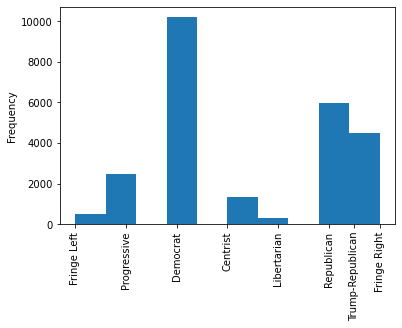

In [65]:
tweets_df_mod['tweet_category'].plot.hist()
plt.xticks([-3,-2,-1,0,1,2,2.5,3], ['Fringe Left', 'Progressive', 'Democrat', 'Centrist', 'Libertarian', 'Republican', 'Trump-Republican', 'Fringe Right'],rotation=90)
plt.show()



In [66]:

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
import sys
from time import time

import numpy as np

from tqdm import tqdm
def plot_pie(col):

    labels = []
    sizes = []

    for x, y in tqdm(Counter(col).items()):
        labels.append(x)
        sizes.append(y)
    print("Number of elements in cluster = ", sum(sizes))
    print("Plotting...")
    # Plot
    plt.pie(sizes, labels=labels, textprops=dict(color="r"))
    
    plt.axis('equal')
    plt.show()


# Source : Official K-means documentation found on Sklearn docs : https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

def kmeans_func(df, col = 'preprocessed_tweets'):

      # Pre-processing begins here
      categories = None
      dataset = df.copy()
      t0 = time()
      hasher = HashingVectorizer(n_features=6, stop_words='english', alternate_sign=False, norm=None)
      vectorizer = make_pipeline(hasher, TfidfTransformer())
      X = vectorizer.fit_transform(dataset[col])

      print("Task completed in %fs" % (time() - t0))
      print("The n_samples: %d, and the n_features: %d" % X.shape)
      print()

      print("Performing dimensionality reduction using LSA")
      t0 = time()

      svd = TruncatedSVD(3)
      normalizer = Normalizer(copy=False)
      lsa = make_pipeline(svd, normalizer)

      X = lsa.fit_transform(X)

      print("done in %fs" % (time() - t0))

      # Print the explained variance after SVD
      explained_variance = svd.explained_variance_ratio_.sum()
      print("Explained variance of the SVD step: ", int(explained_variance * 100))

      # Clustering step
      clus_res = KMeans(n_clusters=8, init='k-means++', max_iter=150, n_init=1,
                  verbose=True)

      print("Clustering sparse data with %s" % clus_res)
      t0 = time()
      clus_res.fit(X)
      print("done in %0.3fs" % (time() - t0))
      print()


      print("Silhouette Coefficient: %0.3f"
            % metrics.silhouette_score(X, clus_res.labels_, sample_size=1000))

      print()
      plot_pie(clus_res.labels_)
      return clus_res.labels_



Extracting features from the training dataset using a sparse vectorizer
done in 1.821271s
n_samples: 111271, n_features: 6

Performing dimensionality reduction using LSA
done in 0.158071s
Explained variance of the SVD step: 46%

Clustering sparse data with KMeans(max_iter=100, n_init=1, verbose=True)
Initialization complete
Iteration 0, inertia 3703.289467120916
Iteration 1, inertia 3393.245159433657
Iteration 2, inertia 3308.406473522463
Iteration 3, inertia 3260.2426868497387
Iteration 4, inertia 3229.7042198478566
Iteration 5, inertia 3205.8381262111534
Iteration 6, inertia 3187.7998135659377
Iteration 7, inertia 3177.0851753559805
Iteration 8, inertia 3170.2645069777363
Iteration 9, inertia 3165.2944490485506
Iteration 10, inertia 3161.4071693110654
Iteration 11, inertia 3158.5875335549945
Iteration 12, inertia 3156.646576887333
Iteration 13, inertia 3155.2728336297523
Iteration 14, inertia 3153.9389780556776
Iteration 15, inertia 3153.0150052639106
Iteration 16, inertia 3152.47674

100%|██████████| 8/8 [00:00<?, ?it/s]

Number of elements in cluster =  111271
Plotting...


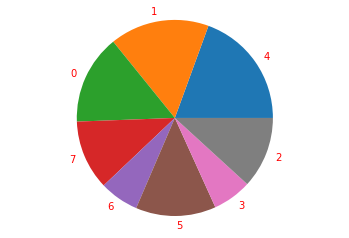

In [67]:
tweets_df_mod['kmeans_labels_tweets'] = kmeans_func(tweets_df_mod, col = 'preprocessed_tweet')

Extracting features from the training dataset using a sparse vectorizer
done in 0.986028s
n_samples: 111271, n_features: 6

Performing dimensionality reduction using LSA
done in 0.136965s
Explained variance of the SVD step: 56%

Clustering sparse data with KMeans(max_iter=100, n_init=1, verbose=True)
Initialization complete
Iteration 0, inertia 5819.009831193111
Iteration 1, inertia 4484.9274415489035
Iteration 2, inertia 4418.881192926156
Iteration 3, inertia 4341.561646913141
Iteration 4, inertia 4252.16785031724
Iteration 5, inertia 4197.013291857814
Iteration 6, inertia 4171.748632897421
Iteration 7, inertia 4154.8288275734885
Iteration 8, inertia 4138.067698773935
Iteration 9, inertia 4117.704884189722
Iteration 10, inertia 4108.887732850222
Iteration 11, inertia 4105.296199659718
Iteration 12, inertia 4101.836302853457
Iteration 13, inertia 4099.352821660814
Iteration 14, inertia 4097.437174327631
Iteration 15, inertia 4095.6525917163194
Iteration 16, inertia 4092.2642211233365
I

100%|██████████| 8/8 [00:00<?, ?it/s]


Iteration 45, inertia 3981.407648204777
Converged at iteration 45: center shift 5.031754370856845e-06 within tolerance 8.945474158146294e-06.
done in 0.713s

Silhouette Coefficient: 0.410

Number of elements in cluster =  111271
Plotting...


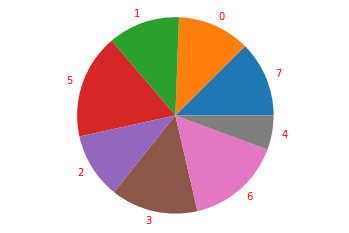

In [68]:
tweets_df_mod['kmeans_labels_desc'] = kmeans_func(tweets_df_mod, col = 'preprocessed_description')

In [69]:
def eval_clustering(col1, col2):

      print("Homogeneity: %0.3f" % metrics.homogeneity_score(tweets_df_mod[col1].to_list(), tweets_df_mod[col2].to_list()))
      print("Completeness: %0.3f" % metrics.completeness_score(tweets_df_mod[col1].to_list(), tweets_df_mod[col2].to_list()))
      print("V-measure: %0.3f" % metrics.v_measure_score(tweets_df_mod[col1].to_list(), tweets_df_mod[col2].to_list()))
      print("Adjusted Rand-Index: %.3f"
            % metrics.adjusted_rand_score(tweets_df_mod[col1].to_list(), tweets_df_mod[col2].to_list()))

eval_clustering('kmeans_labels_desc', 'kmeans_labels_tweets')

Homogeneity: 0.005
Completeness: 0.005
V-measure: 0.005
Adjusted Rand-Index: -0.143


C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))


In [ ]:
def hypothesis_test(test_df, col = 'preprocessed_tweet', threshold = 75):

    pos_score_list = []

    for i in range(50):
        test_df.sample(n = 100)
        res = sentiment_analysis(test_df, col)
        # Percentage of positive tweets is computed and appended to a list
        pos_score_list.append(len(res[1])*100/(len(res[0])))
    
    std = 5
    z = (np.mean(pos_score_list) - threshold) / ((std)/np.sqrt(len(test_df))) 
    print("Test statistic value = {}".format(z))

    if z < -1.96:
        print("Null rejected at 0.05 level")

    else:
        print("Failed to reject the null at the 0.05 level")

In [ ]:
n_df = tweets_df_mod[tweets_df_mod['tweet_category'] > -10]
eval_clustering('kmeans_labels_tweets', 'tweet_category')

In [70]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob


def sentiment_analysis(df, col = 'preprocessed_tweet'):
  num_tweets = len(df.index)

  def percentage(part,whole):
    return 100 * float(part)/float(whole)

  positive = 0
  negative = 0
  neutral = 0
  polarity = 0
  tweet_list = []
  neutral_list = []
  negative_list = []
  positive_list = []
  sent_list = []
  for index, tweet in df.iterrows():
  
    tweet_list.append(tweet[col])
    analysis = TextBlob(tweet[col])
    score = SentimentIntensityAnalyzer().polarity_scores(tweet[col])
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    
    if neg > pos:
      negative_list.append(tweet[col])
      negative += 1
      sent_list.append("Negative")
    elif pos > neg:
      positive_list.append(tweet[col])
      positive += 1
      sent_list.append("Positive")
    elif pos == neg:
      neutral_list.append(tweet[col])
      neutral += 1
      sent_list.append("Neutral")

  positive = percentage(positive, num_tweets)
  negative = percentage(negative, num_tweets)
  neutral = percentage(neutral, num_tweets)
  polarity = percentage(polarity, num_tweets)
  positive = format(positive, '.1f')
  negative = format(negative, '.1f')
  neutral = format(neutral, '.1f')

  #Number of Tweets (Total, Positive, Negative, Neutral)
  # tweet_list = pd.DataFrame(tweet_list)
  # neutral_list = pd.DataFrame(neutral_list)
  # negative_list = pd.DataFrame(negative_list)
  # positive_list = pd.DataFrame(positive_list)
  print("Total Tweets: ",len(tweet_list))
  print("positive number: ",len(positive_list))
  print("negative number: ", len(negative_list))
  print("neutral number: ",len(neutral_list))
  print("Positive Percentage: ", positive)
  print("Negative Percentag : ", negative)
  print("Neutral Percentage : ", neutral)

  return (tweet_list, positive_list, negative_list, neutral_list, sent_list)

In [71]:
k_list = []
for ele in tqdm(set(tweets_df_mod['kmeans_labels_tweets'].to_list())):
    filt = tweets_df_mod['kmeans_labels_tweets'] == ele
    print("Tweet label : " + str(ele))
    k = sentiment_analysis(tweets_df_mod[filt])
    k_list.append(k)
print("##############################################")

  0%|          | 0/8 [00:00<?, ?it/s]

Tweet label : 0


 12%|█▎        | 1/8 [01:46<12:24, 106.39s/it]

Total Tweets:  16435
positive number:  8953
negative number:  5023
neutral number:  2459
Positive Percentage:  54.5
Negative Percentag :  30.6
Neutral Percentage :  15.0
Tweet label : 1


 25%|██▌       | 2/8 [03:44<10:59, 109.96s/it]

Total Tweets:  18239
positive number:  9482
negative number:  5526
neutral number:  3231
Positive Percentage:  52.0
Negative Percentag :  30.3
Neutral Percentage :  17.7
Tweet label : 2


 38%|███▊      | 3/8 [05:09<08:31, 102.33s/it]

Total Tweets:  13119
positive number:  6171
negative number:  3156
neutral number:  3792
Positive Percentage:  47.0
Negative Percentag :  24.1
Neutral Percentage :  28.9
Tweet label : 3


 50%|█████     | 4/8 [05:57<05:44, 86.12s/it] 

Total Tweets:  7158
positive number:  2854
negative number:  1626
neutral number:  2678
Positive Percentage:  39.9
Negative Percentag :  22.7
Neutral Percentage :  37.4
Tweet label : 4


 62%|██████▎   | 5/8 [08:14<05:04, 101.37s/it]

Total Tweets:  21621
positive number:  12436
negative number:  6190
neutral number:  2995
Positive Percentage:  57.5
Negative Percentag :  28.6
Neutral Percentage :  13.9
Tweet label : 5


 75%|███████▌  | 6/8 [09:39<03:13, 96.58s/it] 

Total Tweets:  14717
positive number:  7736
negative number:  3991
neutral number:  2990
Positive Percentage:  52.6
Negative Percentag :  27.1
Neutral Percentage :  20.3
Tweet label : 6


 88%|████████▊ | 7/8 [10:20<01:19, 79.85s/it]

Total Tweets:  7205
positive number:  2676
negative number:  1741
neutral number:  2788
Positive Percentage:  37.1
Negative Percentag :  24.2
Neutral Percentage :  38.7
Tweet label : 7


100%|██████████| 8/8 [11:34<00:00, 86.81s/it]

Total Tweets:  12777
positive number:  6363
negative number:  3328
neutral number:  3086
Positive Percentage:  49.8
Negative Percentag :  26.0
Neutral Percentage :  24.2
##############################################


100%|██████████| 3/3 [00:00<?, ?it/s]

Total Tweets:  111271
positive number:  56671
negative number:  30581
neutral number:  24019
Positive Percentage:  50.9
Negative Percentag :  27.5
Neutral Percentage :  21.6
##############################################
Number of elements in cluster =  111271
Plotting...


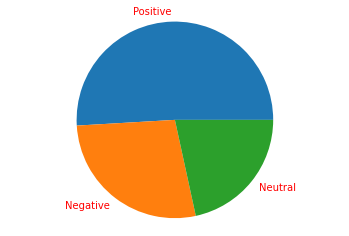

In [72]:
k = sentiment_analysis(tweets_df_mod)

print("##############################################")
plot_pie(k[4])

100%|██████████| 3/3 [00:00<?, ?it/s]

Democratic sentiment distribution
Number of elements in cluster =  13179
Plotting...


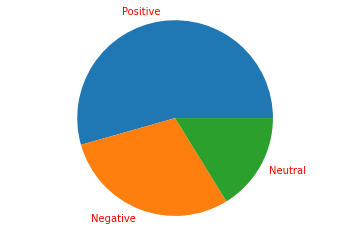

In [73]:
tweets_df_mod['sentiments'] = k[4]
dem_tweets_df = tweets_df_mod[tweets_df_mod['tweet_category'] < 0]
print("Democratic sentiment distribution")
plot_pie(dem_tweets_df['sentiments'].to_list())

100%|██████████| 3/3 [00:00<?, ?it/s]

Republican Tweet Sentiments
Number of elements in cluster =  12099
Plotting...


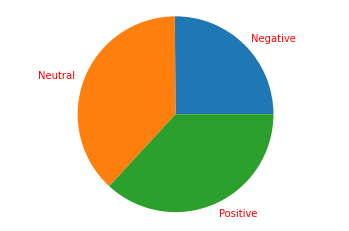

In [74]:

rep_tweets_df = tweets_df_mod[tweets_df_mod['tweet_category'] >= 0]
print("Republican Tweet Sentiments")
plot_pie(rep_tweets_df['sentiments'].to_list())

100%|██████████| 8/8 [00:00<00:00, 7724.32it/s]


Democratic Tweets
Number of elements in cluster =  13179
Plotting...


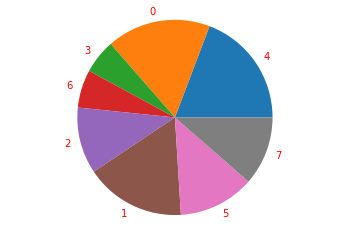

100%|██████████| 8/8 [00:00<00:00, 8089.30it/s]

##################################################
Republican Tweets
Number of elements in cluster =  12099
Plotting...


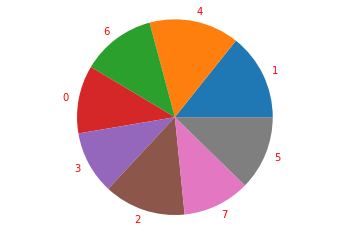

In [75]:
print("Democratic Tweets")
plot_pie(dem_tweets_df['kmeans_labels_tweets'].to_list())

print("##################################################")

print("Republican Tweets")
plot_pie(rep_tweets_df['kmeans_labels_tweets'].to_list())

  0%|          | 0/7 [00:00<?, ?it/s]

For n_clusters = 3 The average silhouette_score is : 0.4361718875437965


 14%|█▍        | 1/7 [04:05<24:34, 245.83s/it]

For n_clusters = 4 The average silhouette_score is : 0.4578628660806257


 29%|██▊       | 2/7 [08:04<20:17, 243.60s/it]

For n_clusters = 5 The average silhouette_score is : 0.427839462052441


 43%|████▎     | 3/7 [2:47:34<3:22:46, 3041.63s/it]

For n_clusters = 6 The average silhouette_score is : 0.4019361121291061


 57%|█████▋    | 4/7 [2:51:40<1:50:08, 2202.95s/it]

For n_clusters = 7 The average silhouette_score is : 0.4206884938066057


 71%|███████▏  | 5/7 [2:55:45<53:51, 1615.54s/it]  

For n_clusters = 8 The average silhouette_score is : 0.4170937438309086


 86%|████████▌ | 6/7 [2:59:48<20:03, 1203.85s/it]

For n_clusters = 9 The average silhouette_score is : 0.3879145705778613


100%|██████████| 7/7 [3:03:46<00:00, 1575.27s/it]


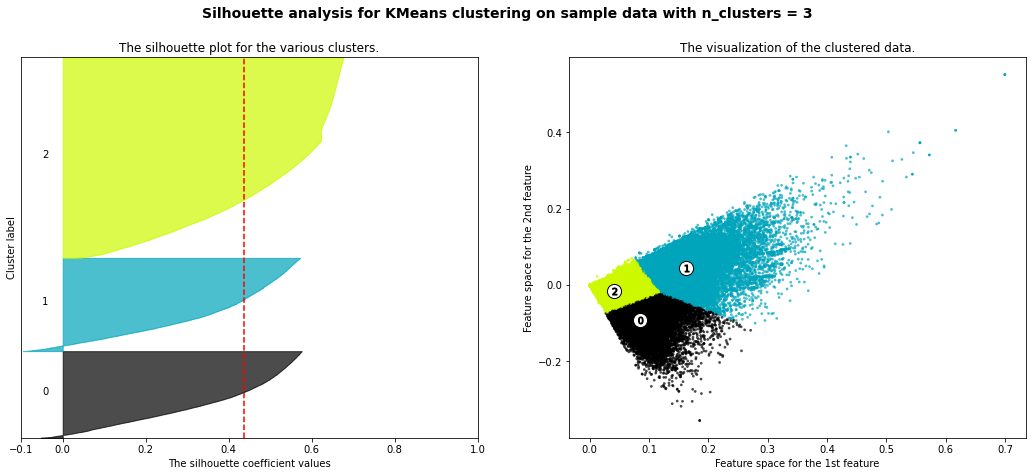

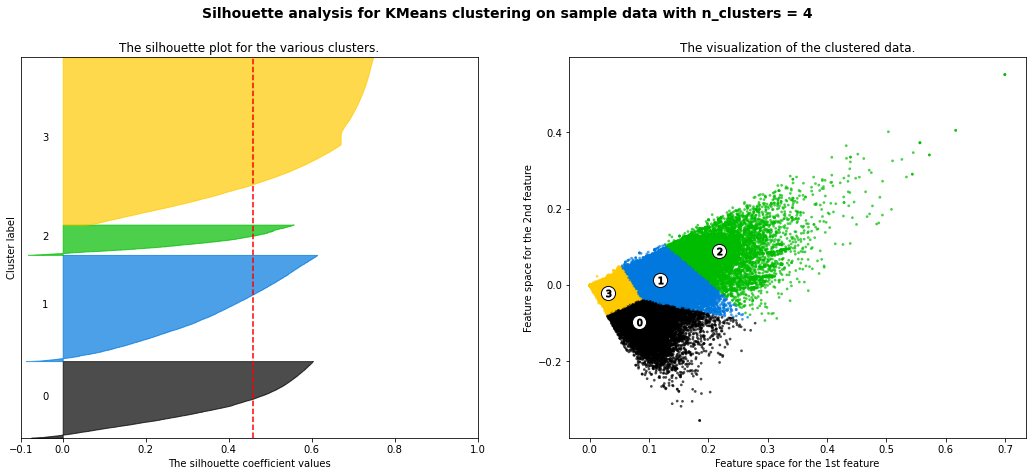

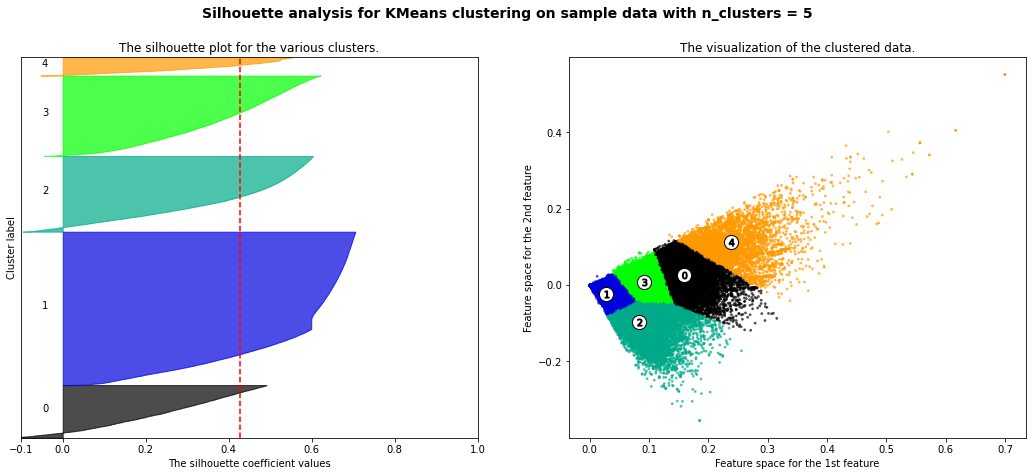

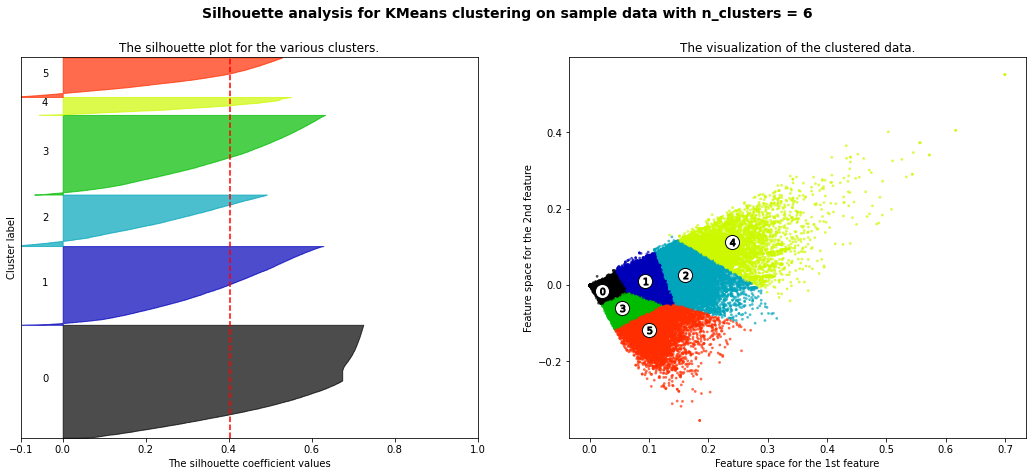

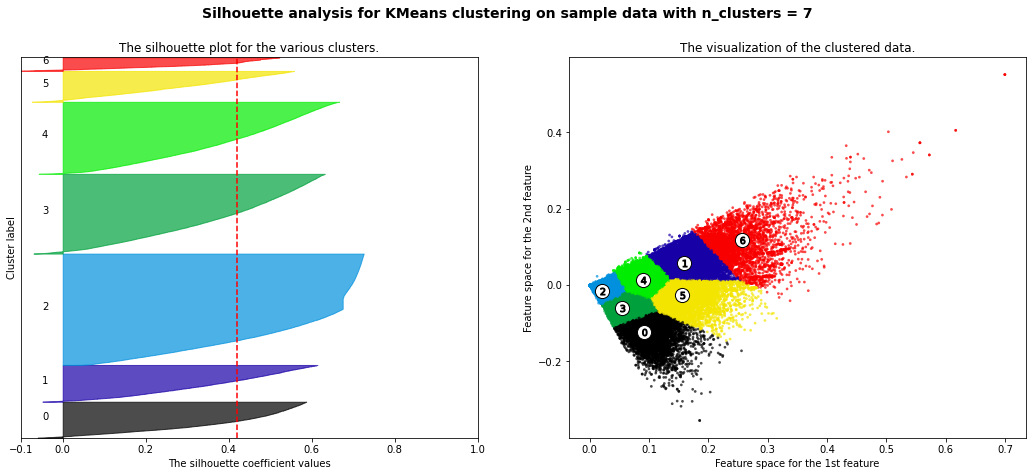

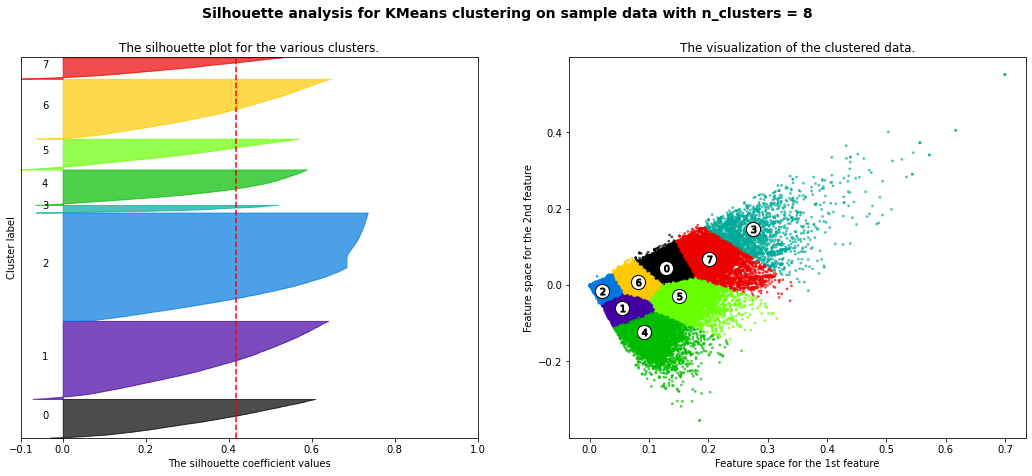

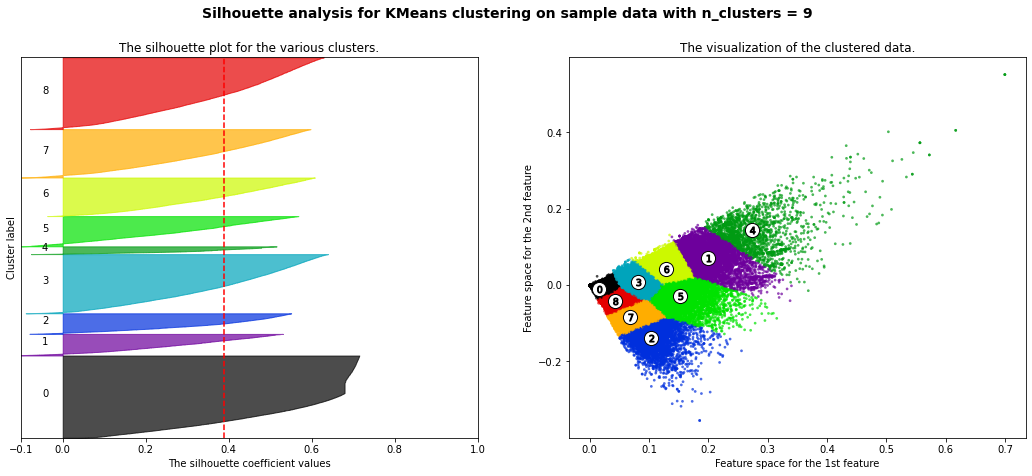

In [76]:
# Source : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html (Official Sklearn documentation)

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import TruncatedSVD  

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import TruncatedSVD

def plot_silhouette(tweets_df_mod):

    vec = TfidfVectorizer(stop_words="english")
    col = "preprocessed_tweet"
    vec.fit(tweets_df_mod[col].values)

    pca = TruncatedSVD(n_components=2)

    features  = vec.transform(tweets_df_mod[col].values)
    features  = pca.fit_transform(features )

    range_n_clusters = [3, 4, 5, 6, 7, 8, 9]
    for n_clusters in tqdm(range_n_clusters):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(features ) + (n_clusters + 1) * 8])

        res = MiniBatchKMeans(n_clusters=n_clusters, random_state=10)
        kmeans_labels = res.fit_predict(features )

        silhouette_avg = silhouette_score(features , kmeans_labels)
        print("Number of clusters =", n_clusters,
              "Average silhouette score is found to be :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(features , kmeans_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[kmeans_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.8)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot")
        ax1.set_xlabel("Silhouette coefficient")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="blue", linestyle="--")

        ax1.set_yticks([])  
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(kmeans_labels.astype(float) / n_clusters)
        ax2.scatter(features [:, 0], features [:, 1], marker='.', s=40, lw=0, alpha=0.8,
                    c=colors, edgecolor='r')

        # Labeling the clusters
        centers = res.cluster_centers_

        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="yellow", alpha=1, s=180, edgecolor='r')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("Distribution of clustered data")
        ax2.set_xlabel("Feature - 1 space")
        ax2.set_ylabel("Feature - 2 space")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = " + str(n_clusters)))

    plt.show()

plot_silhouette(tweets_df_mod)

In [77]:

from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(df, filter, col):
    comment_words = ''
    stopwords = set(STOPWORDS)

    for val in df[filter][col]:

        val = str(val)

        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
                    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

Cluster number 0


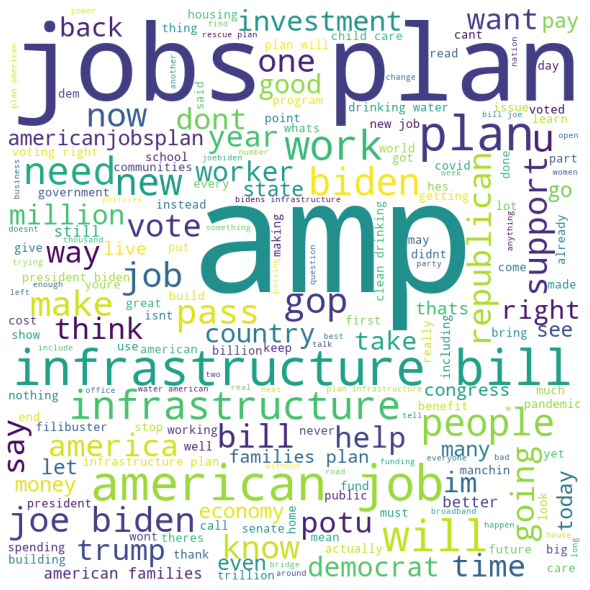

#################################################################################################
Cluster number 1


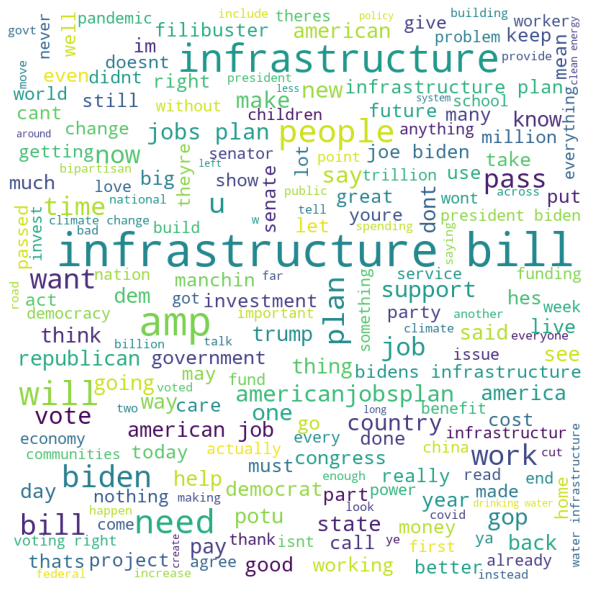

#################################################################################################
Cluster number 2


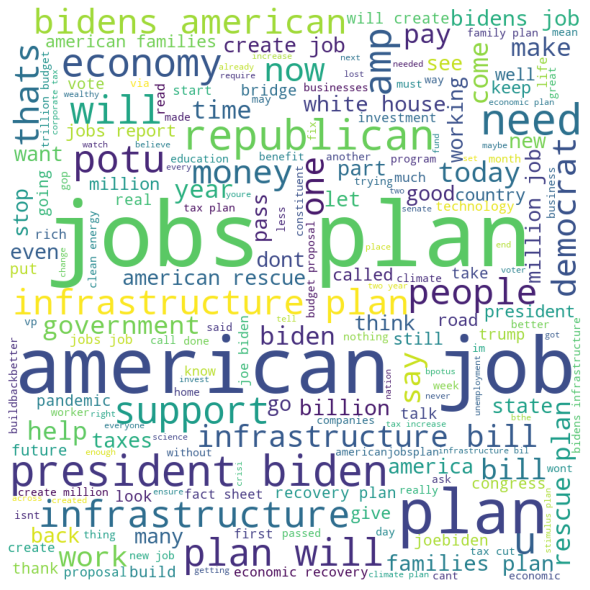

#################################################################################################
Cluster number 3


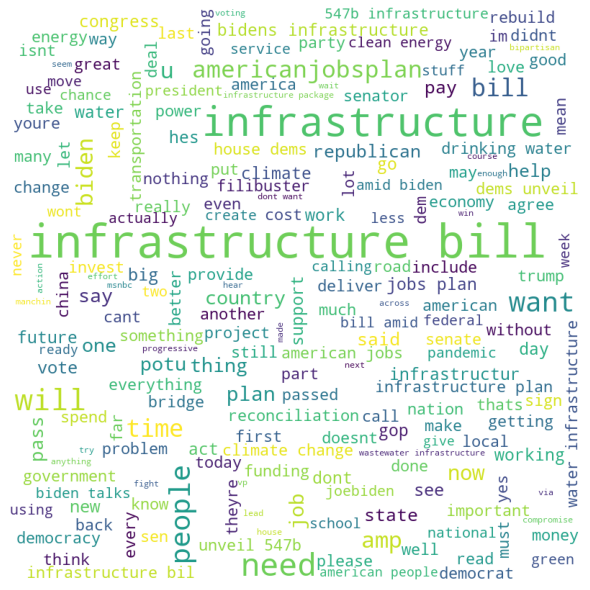

#################################################################################################
Cluster number 4


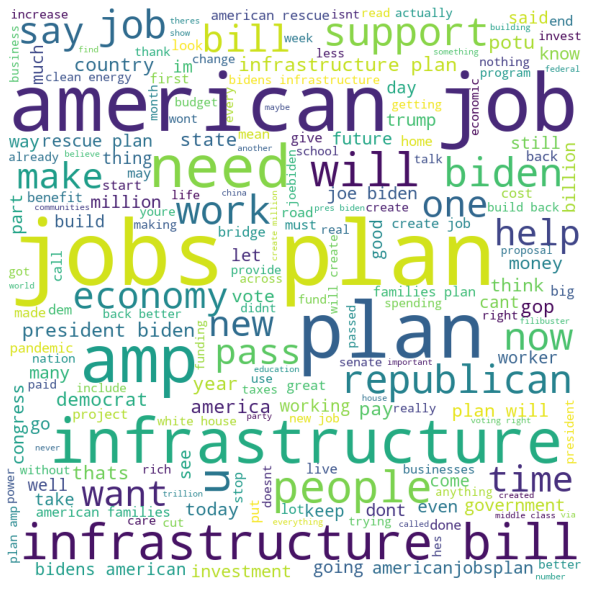

#################################################################################################
Cluster number 5


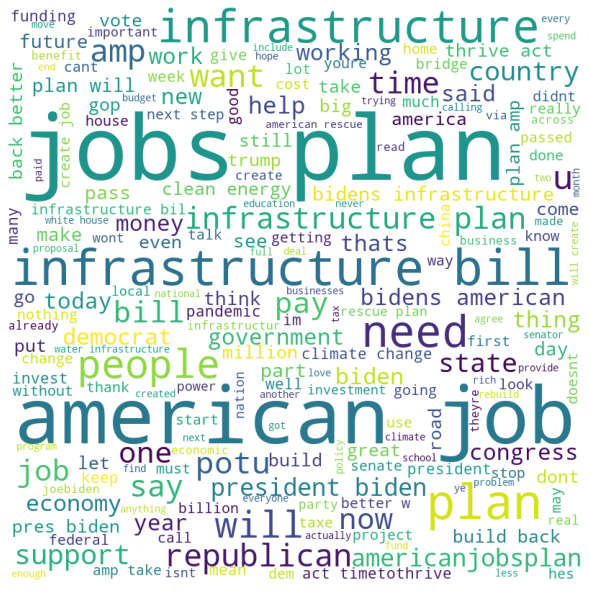

#################################################################################################
Cluster number 6


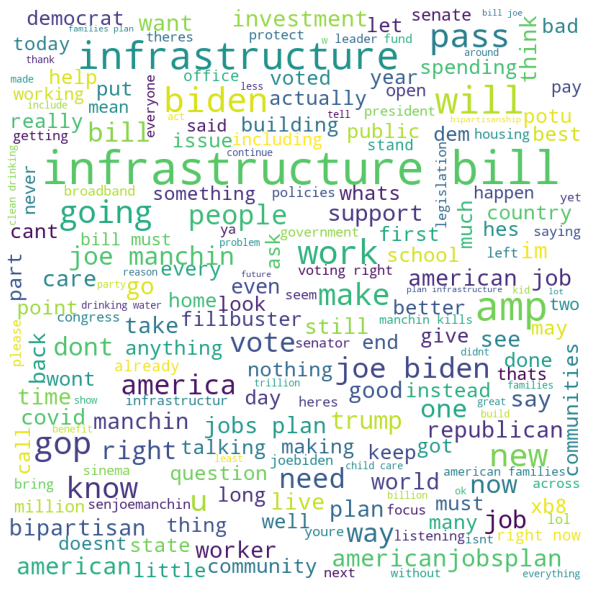

#################################################################################################


In [78]:
for i in range(0,7):
    print("Cluster number {}".format(i))
    plot_wordcloud(df = tweets_df_mod, col = 'preprocessed_tweet', filter = tweets_df_mod['kmeans_labels_tweets'] == i)
    print("#################################################################################################")

100%|██████████| 8/8 [00:00<00:00, 8036.99it/s]

Number of elements in cluster =  25278
Plotting...


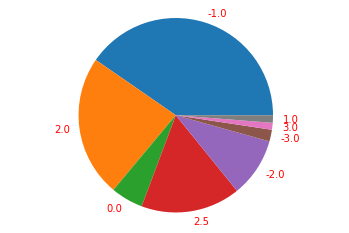

In [79]:
import math
n_df = tweets_df_mod[tweets_df_mod['tweet_category'] > -10]
plot_pie(n_df['tweet_category'].to_list())

In [80]:
cr_df = pd.read_csv('crowd_sourced_pew_tweets.csv')

print(len(cr_df))
cr_df = cr_df.drop(columns = ['Unnamed: 0', 'created_at', 'id', 'reply_to_id', 'screen_name',
       'coordinates', 'place', 'retweet_count', 'favorite_count', 'lang',
       'source', 'is_quote_status', 'user_id', 'user_loc',
       'verified', 'followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'listed_count', 'user_created_at'])

cr_df['tweet_filtered'] = clean_text(cr_df.text.to_list())
cr_df['description_filtered'] = clean_text(cr_df.user_description.to_list())
cr_df = cr_df.drop(columns=['user_description', 'text'])
cr_df.reset_index(drop=True, inplace=True)

print(cr_df)
cr_df = preprocess(cr_df, 'tweet_filtered', 'preprocessed_tweet')
# cr_df = preprocess(cr_df, 'description_filtered', 'preprocessed_description')

cr_df

1985
      tweet category  2017 Pew Research Typology  \
0               -2.0                        -3.0   
1                NaN                        -4.0   
2                NaN                         0.0   
3                NaN                        -4.0   
4                NaN                        -4.0   
...              ...                         ...   
1980             NaN                        -4.0   
1981            -1.0                        -2.6   
1982             NaN                        -4.0   
1983             NaN                        -4.0   
1984             NaN                        -4.0   

                                         tweet_filtered  \
0     SenSchumer: This Senate will work with @POTUS ...   
1     EyeOfTheIdol: Fuck Mitch McConnell and the Rep...   
2     WATCH LIVE: Biden to rally support for infrast...   
3     MSNBC: .@SRuhle: According to US News &amp; Wo...   
4     bNBCNews: U.S. Senate overwhelmingly passes $3...   
...             

,tweet category,2017 Pew Research Typology,tweet_filtered,description_filtered,preprocessed_tweet
0,-2.0,-3.0,SenSchumer: This Senate will work with @POTUS ...,Calming Down class | Parent Success book | Lif...,senschumer this senate will work with potus to...
1,NaN,-4.0,EyeOfTheIdol: Fuck Mitch McConnell and the Rep...,25 years as a bartender a.k.a. a therapist,eyeoftheidol fuck mitch mcconnell and the repu...
2,NaN,0.0,WATCH LIVE: Biden to rally support for infrast...,Get all the major news that matters to you fro...,watch live biden to rally support for infrastr...
3,NaN,-4.0,MSNBC: .@SRuhle: According to US News &amp; Wo...,nan,msnbc sruhle according to us news amp world re...
4,NaN,-4.0,bNBCNews: U.S. Senate overwhelmingly passes $3...,Mother•Grandmother•Family's Everything•The Art...,bnbcnews us senate overwhelmingly passes 35b b...
...,...,...,...,...,...
1980,NaN,-4.0,@tribelaw @waltshaub @tedcruz I keep asking th...,nan,tribelaw waltshaub tedcruz i keep asking the s...
1981,-1.0,-2.6,@tribelaw @waltshaub @tedcruz I bet if Biden's...,nan,tribelaw waltshaub tedcruz i bet if bidens inf...
1982,NaN,-4.0,mmpadellan: Republicans are against:- The COVI...,#ProChoice #Liberal #CoeXisT #HumanityFirst #H...,mmpadellan republicans are against the covid r...
1983,NaN,-4.0,bBtfsplkJ: @mkraju Which = $189B when the GOP ...,nan,bbtfsplkj mkraju which 189b when the gop acco...


100%|██████████| 8/8 [00:00<00:00, 8015.87it/s]

Extracting features from the training dataset using a sparse vectorizer
done in 0.079218s
n_samples: 1985, n_features: 6

Performing dimensionality reduction using LSA
done in 0.018998s
Explained variance of the SVD step: 48%

Clustering sparse data with KMeans(max_iter=100, n_init=1, verbose=True)
Initialization complete
Iteration 0, inertia 55.739513500160996
Iteration 1, inertia 48.195332451634194
Iteration 2, inertia 46.61542660327812
Iteration 3, inertia 45.07567481599776
Iteration 4, inertia 44.52359067479743
Iteration 5, inertia 44.35751478992762
Iteration 6, inertia 44.286673229585816
Iteration 7, inertia 44.24423965896647
Iteration 8, inertia 44.23125298385911
Iteration 9, inertia 44.22659462037751
Converged at iteration 9: center shift 4.537793265448081e-06 within tolerance 4.941694627925001e-06.
done in 0.022s

Silhouette Coefficient: 0.377

Number of elements in cluster =  1985
Plotting...


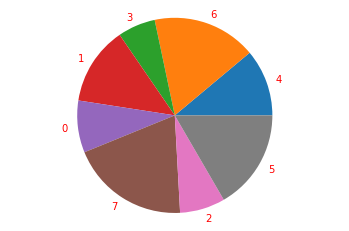

In [81]:
cr_df['kmeans_labels_tweets'] = kmeans_func(cr_df, col = 'preprocessed_tweet')

In [82]:
print(cr_df)
cr_df['2017 Pew Research Typology'] = cr_df['2017 Pew Research Typology'].apply(lambda x : round(x, 0))

print("Homogeneity: %0.3f" % metrics.homogeneity_score(cr_df['kmeans_labels_tweets'].to_list(), cr_df['2017 Pew Research Typology'].to_list()))
print("Completeness: %0.3f" % metrics.completeness_score(cr_df['kmeans_labels_tweets'].to_list(), cr_df['2017 Pew Research Typology'].to_list()))
print("V-measure: %0.3f" % metrics.v_measure_score(cr_df['kmeans_labels_tweets'].to_list(), cr_df['2017 Pew Research Typology'].to_list()))
print("Adjusted Rand-Index: %.3f"
    % metrics.adjusted_rand_score(cr_df['kmeans_labels_tweets'].to_list(), cr_df['2017 Pew Research Typology'].to_list()))

      tweet category  2017 Pew Research Typology  \
0               -2.0                        -3.0   
1                NaN                        -4.0   
2                NaN                         0.0   
3                NaN                        -4.0   
4                NaN                        -4.0   
...              ...                         ...   
1980             NaN                        -4.0   
1981            -1.0                        -2.6   
1982             NaN                        -4.0   
1983             NaN                        -4.0   
1984             NaN                        -4.0   

                                         tweet_filtered  \
0     SenSchumer: This Senate will work with @POTUS ...   
1     EyeOfTheIdol: Fuck Mitch McConnell and the Rep...   
2     WATCH LIVE: Biden to rally support for infrast...   
3     MSNBC: .@SRuhle: According to US News &amp; Wo...   
4     bNBCNews: U.S. Senate overwhelmingly passes $3...   
...                  

In [83]:
k3 = sentiment_analysis(cr_df)

Total Tweets:  1985
positive number:  989
negative number:  572
neutral number:  424
Positive Percentage:  49.8
Negative Percentag :  28.8
Neutral Percentage :  21.4


100%|██████████| 9/9 [00:00<?, ?it/s]

Positive
Number of elements in cluster =  989
Plotting...


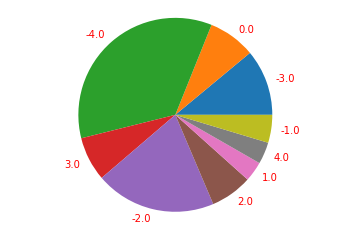

100%|██████████| 9/9 [00:00<?, ?it/s]

Neutral
Number of elements in cluster =  424
Plotting...


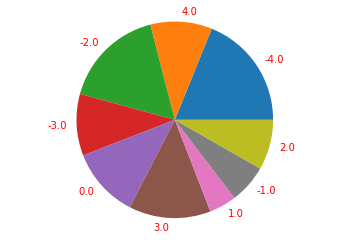

100%|██████████| 9/9 [00:00<00:00, 8994.22it/s]


Negative
Number of elements in cluster =  572
Plotting...


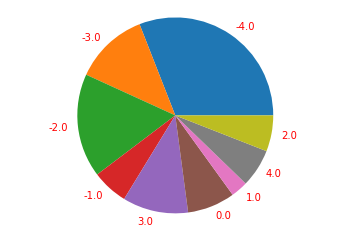

In [84]:
cr_df['sentiments'] = k3[4]

labels = set(k3[4])

for ele in labels:
    print(ele)
    plot_pie(cr_df[cr_df['sentiments'] == ele]['2017 Pew Research Typology'].to_list())